# 采用多种方式进行特征选择

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [2]:
df_train = pd.read_csv('../dataset/pfm_train.csv')
df_test = pd.read_csv('../dataset/pfm_test.csv')

# 前文分析过，两个变量方差为0，可以删除。
# EmployeeNumber是唯一识别号码，删除
df_train.drop(['Over18', 'StandardHours', 'EmployeeNumber'],
              axis=1, inplace=True)
df_test.drop(['Over18', 'StandardHours', 'EmployeeNumber'],
              axis=1, inplace=True)

# 预测变量
target_var = 'Attrition'

# 连续变量
continuous_var = ['Age', 'MonthlyIncome', 'TotalWorkingYears',
                  'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                  'YearsWithCurrManager']
# 分类变量
categorical_var = [ x for x in df_train.columns if x not in continuous_var
                                               and x != target_var]

# 数据类型
# 数值型
numeric_var = [x for x in df_train.dtypes.index if df_train.dtypes[x] != 'object'
                                               and x != target_var]
# 字符型
character_var = [ x for x in df_train.dtypes.index if x not in numeric_var
                                                  and x != target_var]

In [3]:
# 将连续变量标准化
scaler = MinMaxScaler()
df_train[continuous_var] = scaler.fit_transform(df_train[continuous_var])
df_test[continuous_var] = scaler.transform(df_test[continuous_var])

# 将字符变量数值化
le = LabelEncoder()
for col in character_var:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])
    
# 为分类变量常见虚拟变量
for col in categorical_var:
    dummy = pd.get_dummies(df_train[col], prefix=col)
    # 合并虚拟变量
    df_train = pd.concat([df_train, dummy], axis=1)
    # 删除原变量
    df_train.drop([col], axis=1, inplace=True)
    
    # 测试集进行同样操作
    dummy = pd.get_dummies(df_test[col], prefix=col)
    df_test = pd.concat([df_test, dummy], axis=1)
    df_test.drop([col], axis=1, inplace=True)

In [62]:
predictor_var = [x for x in df_train.columns if x != target_var]

clf = LogisticRegression(penalty="l1", C=0.1)

In [63]:
seed = 7
size = 0.33
X_train, X_test, y_train, y_test = train_test_split(df_train[predictor_var], df_train[target_var],
                                                    test_size=size, random_state=seed)

#for x in range(N):
#    n_features = x + 1
#    selector = RFE(clf, n_features_to_select=n_features)
#    feature = selector.fit_transform(X_train,y_train)
#
#    score = selector.score(X_test, y_test)
#    score_list.append(score)
#    if score > score_temp:
#        score_temp = score
#        num_temp = n_features
#        support = pd.DataFrame({'Wrapper':selector.support_}, index=predictor_var)

In [64]:
# 使用递归消除法进行特征选择
start = time.time()
rfecv = RFECV(clf, step=1, cv=10,scoring='accuracy')
rfecv.fit(X_train,y_train)
print('time : %f'%(time.time()-start))
support = pd.DataFrame({'Wrapper':rfecv.support_}, index=predictor_var)
print('n_features = %d'%(rfecv.n_features_))

time : 7.147693
n_features = 4


In [67]:
# 带L1惩罚项的特征选择
start = time.time()
selector = SelectFromModel(clf)
selector.fit(X_train,y_train)
support['Embedded'] = selector.get_support()
print('time : %f'%(time.time()-start))

time : 0.010009


In [66]:
support.apply(lambda x: x.value_counts())

,Wrapper,Embedded
False,128,119
True,4,13


Embedded法的速度远高于Wrapper法，在选择的数量上，Embedded筛选出13个，Wrapper选择出4个。

In [68]:
support[support['Embedded']==True]

,Wrapper,Embedded
Age,False,True
Department_1,True,True
JobInvolvement_3,False,True
JobLevel_1,True,True
JobLevel_2,False,True
JobSatisfaction_4,False,True
MaritalStatus_0,False,True
OverTime_0,True,True
PerformanceRating_3,False,True
RelationshipSatisfaction_4,False,True


In [69]:
# 利用卡方检验选择变量
selector = SelectKBest(chi2, 'all')
X_train_new = selector.fit_transform(X_train, y_train)

In [70]:
support['chi2_scores'] = selector.scores_
support['chi2_pvalues'] = selector.pvalues_
support.sort_values(by='chi2_scores', ascending=False)

,Wrapper,Embedded,chi2_scores,chi2_pvalues
OverTime_1,False,False,41.654434,1.089181e-10
StockOptionLevel_0,True,True,29.075341,6.961748e-08
JobRole_8,False,False,28.512653,9.308814e-08
MaritalStatus_2,False,False,22.162387,2.505343e-06
JobLevel_1,True,True,18.064080,2.135931e-05
JobInvolvement_1,False,False,16.488635,4.894256e-05
OverTime_0,True,True,15.620413,7.741436e-05
StockOptionLevel_1,False,True,13.374015,2.551346e-04
DistanceFromHome_24,False,False,12.148254,4.913385e-04
JobSatisfaction_1,False,False,10.510275,1.187126e-03


In [71]:
# 利用f_classif选择变量
selector = SelectKBest(f_classif, 'all')
X_train_new = selector.fit_transform(X_train, y_train)
support['f_classif_scores'] = selector.scores_
support['f_classif_pvalues'] = selector.pvalues_
support.sort_values(by='f_classif_scores', ascending=False)

,Wrapper,Embedded,chi2_scores,chi2_pvalues,f_classif_scores,f_classif_pvalues
OverTime_0,True,True,15.620413,7.741436e-05,61.932403,1.273119e-14
OverTime_1,False,False,41.654434,1.089181e-10,61.932403,1.273119e-14
StockOptionLevel_0,True,True,29.075341,6.961748e-08,52.646163,1.016613e-12
MaritalStatus_2,False,False,22.162387,2.505343e-06,33.877038,8.767060e-09
JobRole_8,False,False,28.512653,9.308814e-08,31.490907,2.839712e-08
JobLevel_1,True,True,18.064080,2.135931e-05,30.386834,4.901617e-08
TotalWorkingYears,False,False,3.237442,7.197293e-02,25.006616,7.151180e-07
StockOptionLevel_1,False,True,13.374015,2.551346e-04,23.938818,1.222634e-06
MonthlyIncome,False,False,4.082658,4.332545e-02,19.881643,9.526022e-06
YearsInCurrentRole,False,False,3.360566,6.677512e-02,19.654531,1.069452e-05


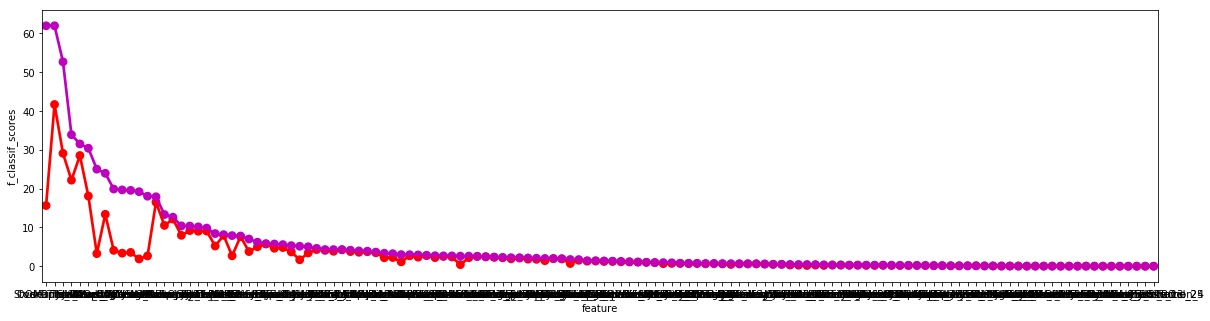

In [72]:
support['feature'] = support.index.tolist()
support['temp'] = 0.05
new_support = support.sort_values(by='f_classif_scores', ascending=False)
fig = plt.figure(figsize=(20,5))
sns.pointplot(x='feature', y='chi2_scores', data=new_support, color='r')
sns.pointplot(x='feature', y='f_classif_scores', data=new_support, color='m')